# Using the trained Bayesian neural network for predictions

We start with loading all the needed modules

In [4]:
# importing all modules needed for prediction
import pickle 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# machine learning libraries
import tensorflow as tf
import edward as ed

# bayesian neural network
from network_details import BayesianNeuralNetwork

# Constructing the Bayesian neural network instance

Everything we have stored on disk are the parameters of the fully trained Bayesian neural network instance. In order to use the Bayesian neural network for predictions, we therefore first need to construct the network architecture. In this procedure, the computational graph for network prediction is constructed, which combines the weights and biases stored on disk. The construction consists of the following steps:
* Initialize an abstract network instance
* Construct the network architecture which was found to best approximate the given dataset
* Load weights and biases for the constructed network architecture

Examples for all three steps are in the cell below

## Construct the Bayesian neural network

Unfortunately we only have a set of network parameters stored in the `model/` directory, which means that we neet to construct the network first. The construction consists of the following steps:
* Load the dataset on which we trained the network, to provide a context for network predictions. We can then easily compare the dataset used for network training with datasets used for predictions to estimate whether the network could give meaningful predictions
* Load details about the training set with which the network was trained. This includes the means and standard deviations of features and targets in the training set.
* Construct the network. In this step, we assemble the computational graph for network training and prediction. Although this step might take a little while, it significantly speeds up the prediction process
* Load the network parameters, i.e. weights and biases.

Examples for all steps are in the cells below

In [5]:
# initializing an abstract network object
bnn = BayesianNeuralNetwork()

In [6]:
# get training set details
details = pickle.load(open('model/training_set_specs.pkl', 'rb'))
for att in ['mean_features', 'std_features', 'mean_targets', 'std_targets', 'max_targets', 'min_targets']:
    setattr(bnn.manager, att, details[att])

In [7]:
# constructing the network architecture 
bnn.construct_networks()

... constructing network


In [8]:
# loading the network parameters
sess  = ed.get_session()
saver = tf.train.Saver()
saver.restore(sess, 'model/bnn.ckpt')
#saver.restore(sess, 'model/tmp_bnn||.ckpt')

INFO:tensorflow:Restoring parameters from model/bnn.ckpt


## Predictions with the Bayesian neural network model

Now we can jump to dissociation transfer time predictions with the trained network architecture. The cells below outline a possible workflow for predicting dissociation times for an arbitrary set of geometries.

### Step 1: Getting dissociation time estimates from molecule geometries

The cell below implements an example for obtaining dissociation time estimates from a set of geometries. To predict dissociation times from the trained network, use the `network.predict` method. This function requires a set of geometries in the form of a numpy array of the shape `[?, 24]`, where `?` can be an arbitrary number (i.e. number of geometries for which dissociation times are to be predicted). The geometries are expected to be provided in the same format as in the dataset used for training.

The `predict` function will automatically rotate the provided geometries into normal mode space and rescale them based on the rescaling function determined from the dataset on which the networks were trained. The function will then draw a number of network instances from the stored distributions to predict dissociation times. 

The syntax of the `predict` function reads:
```python
    averages, uncertainties, all_samples = network.predict(geometries, n_post = 200)
```
where `geometries` denotes the geometries for which dissociation times are to be predicted. The optional argument `n_post` denotes the number of network instances to draw from the BNN distributions. In general, a larger `n_post` results in a more robust prediction, but increases the time needed for predictions. I found $200$ to be a reliable upper bound, i.e. increasing `n_post` beyond $200$ didn't affect the predictions much. Reasonable predictions can certainly be obtained with smaller values of `n_post`.

The function returns the predictions of all sampled networks (`all_samples`) in the form of a `[n_post, ?]` matrix, where `?` denotes the number of geometries for which dissociation times were predicted. The network average of these predictions is stored in `averages`, the standard deviation is stored in `uncertainties`.

In [9]:
# lets load some geometries and momenta from the dataset
from train_network import DataManager
manager = DataManager('RawData/colors_green.pkl')

In [19]:
# loading the network parameters
sess  = ed.get_session()
saver = tf.train.Saver()
saver.restore(sess, 'model/bnn.ckpt')
#saver.restore(sess, 'model/tmp_bnn||.ckpt')

INFO:tensorflow:Restoring parameters from model/bnn.ckpt


In [20]:
predictions, uncertainties, _all_samples = bnn.predict(manager.features, n_post = 200, rescale = False)

### Step 2: Analyzing precited dissociation times

Next, we can look at the predicted dissociation times and compare them to our expectations, i.e. the target dissociation times on which we trained the network. In the following cells, points from the training set will always be highlighted in black, points from the validation set in green and points from the test set in red.

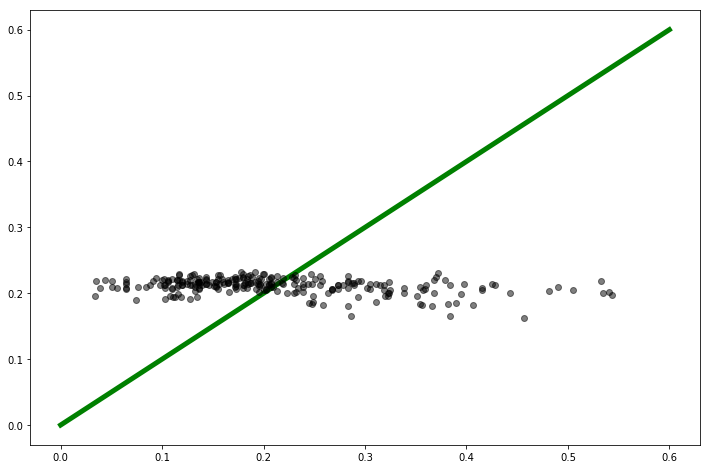

In [21]:
fig = plt.figure(figsize = (12, 8))
plt.plot([0, 0.6], [0, 0.6], color = 'g', lw = 5)
plt.plot(manager.values, predictions, ls = '', marker = 'o', color = 'k', alpha = 0.5)
plt.show()